In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [80]:
df = pd.read_excel('Real estate valuation data set.xlsx')  

# Rename columns for easier handling
df.columns = ['No', 'X1_transaction_date', 'X2_house_age', 'X3_distance_to_MRT', 
              'X4_convenience_stores', 'X5_latitude', 'X6_longitude', 'Y_house_price']

# Drop unnecessary column 'No' and 'X1_transaction_date'
df = df.drop(['No', 'X1_transaction_date'], axis=1)

# Separate features (X) and target (y)
X = df.drop('Y_house_price', axis=1).values
y = df['Y_house_price'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of training and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)

X_train shape: (331, 5)
X_test shape: (83, 5)
y_train shape: (331,)


In [81]:
# Define Mean Squared Error (MSE) loss function for regression
def compute_mse_loss(X, y, weights, bias):
    m = len(y)
    predictions = X @ weights + bias
    loss = (1/(2*m)) * np.sum((predictions - y) ** 2)  # MSE
    return loss

# Prediction and RMSE calculation functions
def predict(X, weights, bias):
    return X @ weights + bias

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Gradient Descent Optimizer class 
class GradientDescentOptimizer:
    def __init__(self, step_rate=0.01, num_iterations=100):
        self.step_rate = step_rate
        self.num_iterations = num_iterations
        self.loss_history = []

    # Batch Gradient Descent
    def batch(self, X_data, y_labels):
        num_samples, num_features = X_data.shape
        parameters = np.zeros(num_features)
        bias = 0

        for _ in range(self.num_iterations):
            predictions = X_data @ parameters + bias  # Linear prediction
            grad = (1/num_samples) * X_data.T @ (predictions - y_labels)
            bias_grad = (1/num_samples) * np.sum(predictions - y_labels)

            parameters -= self.step_rate * grad
            bias -= self.step_rate * bias_grad

            loss = compute_mse_loss(X_data, y_labels, parameters, bias)
            self.loss_history.append(loss)
            
        return parameters, bias

    # Mini-Batch Gradient Descent
    def mini_batch(self, features, targets, batch_size=32):
        sample_count, feature_count = features.shape
        weights = np.zeros(feature_count)
        bias = 0

        for _ in range(self.num_iterations):
            shuffled_indices = np.random.permutation(sample_count)
            X_perm = features[shuffled_indices]
            y_perm = targets[shuffled_indices]

            for start_idx in range(0, sample_count, batch_size):
                X_batch = X_perm[start_idx:start_idx + batch_size]
                y_batch = y_perm[start_idx:start_idx + batch_size]

                predictions = X_batch @ weights + bias  # Linear prediction
                weight_update = (1/len(y_batch)) * X_batch.T @ (predictions - y_batch)
                bias_update = (1/len(y_batch)) * np.sum(predictions - y_batch)

                weights -= self.step_rate * weight_update
                bias -= self.step_rate * bias_update

            loss = compute_mse_loss(features, targets, weights, bias)
            self.loss_history.append(loss)

        return weights, bias

    # Stochastic Gradient Descent
    def stochastic(self, input_data, output_data):
        total_samples, total_features = input_data.shape
        coeffs = np.zeros(total_features)
        bias = 0
        
        for _ in range(self.num_iterations):
            for _ in range(total_samples):
                rand_sample = np.random.randint(total_samples)
                X_single = input_data[rand_sample:rand_sample+1]
                y_single = output_data[rand_sample:rand_sample+1]

                prediction = X_single @ coeffs + bias  # Linear prediction
                coeff_grad = X_single.T @ (prediction - y_single)
                bias_grad = np.sum(prediction - y_single)

                coeffs -= self.step_rate * coeff_grad
                bias -= self.step_rate * bias_grad

            loss = compute_mse_loss(input_data, output_data, coeffs, bias)
            self.loss_history.append(loss)

        return coeffs, bias

    # Momentum Gradient Descent
    def momentum(self, X_matrix, y_vector, momentum_factor=0.9):
        n_samples, n_features = X_matrix.shape
        model_params = np.zeros(n_features)
        bias = 0
        velocity_vector = np.zeros(n_features)
        bias_velocity = 0

        for _ in range(self.num_iterations):
            predictions = X_matrix @ model_params + bias  # Linear prediction
            param_grad = (1/n_samples) * X_matrix.T @ (predictions - y_vector)
            bias_grad = (1/n_samples) * np.sum(predictions - y_vector)

            velocity_vector = momentum_factor * velocity_vector - self.step_rate * param_grad
            bias_velocity = momentum_factor * bias_velocity - self.step_rate * bias_grad

            model_params += velocity_vector
            bias += bias_velocity

            loss = compute_mse_loss(X_matrix, y_vector, model_params, bias)
            self.loss_history.append(loss)

        return model_params, bias

    # RMSprop Gradient Descent
    def rmsprop(self, X_input, y_target, decay_rate=0.9, tiny_value=1e-8):
        num_rows, num_cols = X_input.shape
        coefficients = np.zeros(num_cols)
        bias = 0
        moving_avg = np.zeros(num_cols)
        bias_avg = 0

        for _ in range(self.num_iterations):
            predictions = X_input @ coefficients + bias  # Linear prediction
            grad_vector = (1/num_rows) * X_input.T @ (predictions - y_target)
            bias_grad = (1/num_rows) * np.sum(predictions - y_target)

            moving_avg = decay_rate * moving_avg + (1 - decay_rate) * (grad_vector ** 2)
            bias_avg = decay_rate * bias_avg + (1 - decay_rate) * (bias_grad ** 2)

            coefficients -= self.step_rate * grad_vector / (np.sqrt(moving_avg) + tiny_value)
            bias -= self.step_rate * bias_grad / (np.sqrt(bias_avg) + tiny_value)

            loss = compute_mse_loss(X_input, y_target, coefficients, bias)
            self.loss_history.append(loss)

        return coefficients, bias

    # Adam Gradient Descent
    def adam(self, X_features, y_labels, b1=0.9, b2=0.999, small_eps=1e-8):
        sample_size, feature_size = X_features.shape
        params = np.zeros(feature_size)
        bias = 0
        momentum = np.zeros(feature_size)
        velocity = np.zeros(feature_size)
        bias_momentum = 0
        bias_velocity = 0
        iter_count = 0

        for _ in range(self.num_iterations):
            iter_count += 1
            predictions = X_features @ params + bias  # Linear prediction
            grad_vals = (1/sample_size) * X_features.T @ (predictions - y_labels)
            bias_grad = (1/sample_size) * np.sum(predictions - y_labels)

            momentum = b1 * momentum + (1 - b1) * grad_vals
            velocity = b2 * velocity + (1 - b2) * (grad_vals ** 2)
            bias_momentum = b1 * bias_momentum + (1 - b1) * bias_grad
            bias_velocity = b2 * bias_velocity + (1 - b2) * (bias_grad ** 2)

            momentum_corr = momentum / (1 - b1 ** iter_count)
            velocity_corr = velocity / (1 - b2 ** iter_count)
            bias_mom_corr = bias_momentum / (1 - b1 ** iter_count)
            bias_vel_corr = bias_velocity / (1 - b2 ** iter_count)

            params -= self.step_rate * momentum_corr / (np.sqrt(velocity_corr) + small_eps)
            bias -= self.step_rate * bias_mom_corr / (np.sqrt(bias_vel_corr) + small_eps)

            loss = compute_mse_loss(X_features, y_labels, params, bias)
            self.loss_history.append(loss)

        return params, bias

In [82]:
# Initialize optimizers
optimizers = {
    'Batch GD': GradientDescentOptimizer(step_rate=0.1, num_iterations=200),
    'Mini-Batch GD': GradientDescentOptimizer(step_rate=0.1, num_iterations=200),
    'Stochastic GD': GradientDescentOptimizer(step_rate=0.0001, num_iterations=200),
    'Momentum': GradientDescentOptimizer(step_rate=0.1, num_iterations=200),
    'RMSprop': GradientDescentOptimizer(step_rate=0.9, num_iterations=200),
    'Adam': GradientDescentOptimizer(step_rate=0.9, num_iterations=200)
}

Training Batch GD...
RMSE: 7.3788


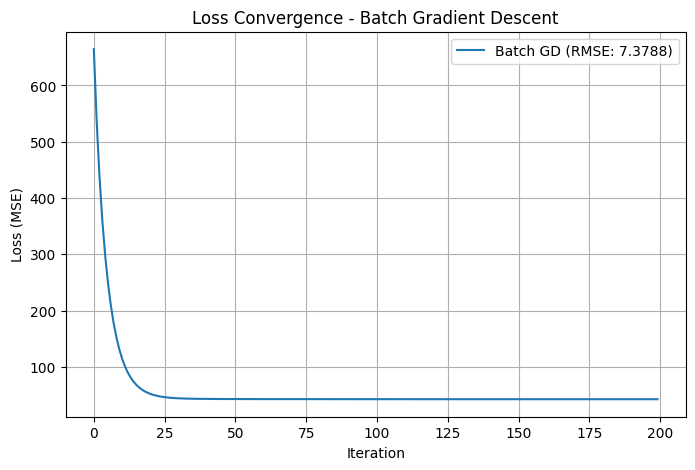

In [83]:
# Train Batch Gradient Descent
print("Training Batch GD...")
optimizer_batch = optimizers['Batch GD']
optimizer_batch.loss_history = []  # Reset loss history
weights_batch, bias_batch = optimizer_batch.batch(X_train, y_train)
y_pred_batch = predict(X_test, weights_batch, bias_batch)
rmse_batch = rmse(y_test, y_pred_batch)
print(f"RMSE: {rmse_batch:.4f}")

# Plot loss convergence
plt.figure(figsize=(8, 5))
plt.plot(optimizer_batch.loss_history, label=f'Batch GD (RMSE: {rmse_batch:.4f})')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('Loss Convergence - Batch Gradient Descent')
plt.legend()
plt.grid()
plt.show()

Training Mini-Batch GD...
RMSE: 7.3970


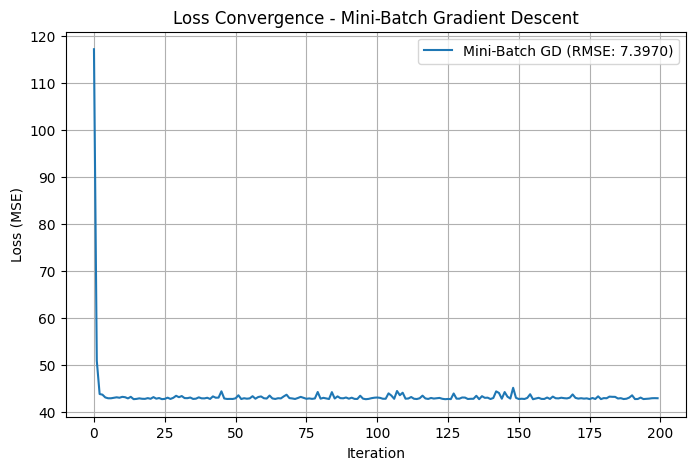

In [84]:
# Train Mini-Batch Gradient Descent
print("Training Mini-Batch GD...")
optimizer_mini = optimizers['Mini-Batch GD']
optimizer_mini.loss_history = []  # Reset loss history
weights_mini, bias_mini = optimizer_mini.mini_batch(X_train, y_train)
y_pred_mini = predict(X_test, weights_mini, bias_mini)
rmse_mini = rmse(y_test, y_pred_mini)
print(f"RMSE: {rmse_mini:.4f}")

# Plot loss convergence
plt.figure(figsize=(8, 5))
plt.plot(optimizer_mini.loss_history, label=f'Mini-Batch GD (RMSE: {rmse_mini:.4f})')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('Loss Convergence - Mini-Batch Gradient Descent')
plt.legend()
plt.grid()
plt.show()

Training Stochastic GD...
RMSE: 7.3321


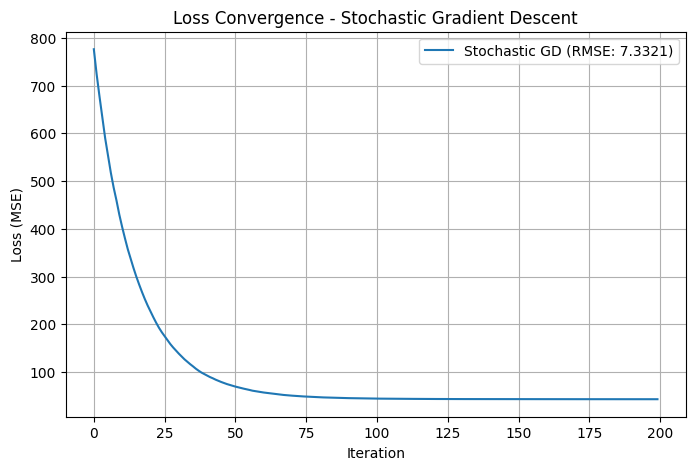

In [85]:
# Train Stochastic Gradient Descent
print("Training Stochastic GD...")
optimizer_sgd = optimizers['Stochastic GD']
optimizer_sgd.loss_history = []  # Reset loss history
weights_sgd, bias_sgd = optimizer_sgd.stochastic(X_train, y_train)
y_pred_sgd = predict(X_test, weights_sgd, bias_sgd)
rmse_sgd = rmse(y_test, y_pred_sgd)
print(f"RMSE: {rmse_sgd:.4f}")

# Plot loss convergence
plt.figure(figsize=(8, 5))
plt.plot(optimizer_sgd.loss_history, label=f'Stochastic GD (RMSE: {rmse_sgd:.4f})')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('Loss Convergence - Stochastic Gradient Descent')
plt.legend()
plt.grid()
plt.show()

Training Momentum...
RMSE: 7.3879


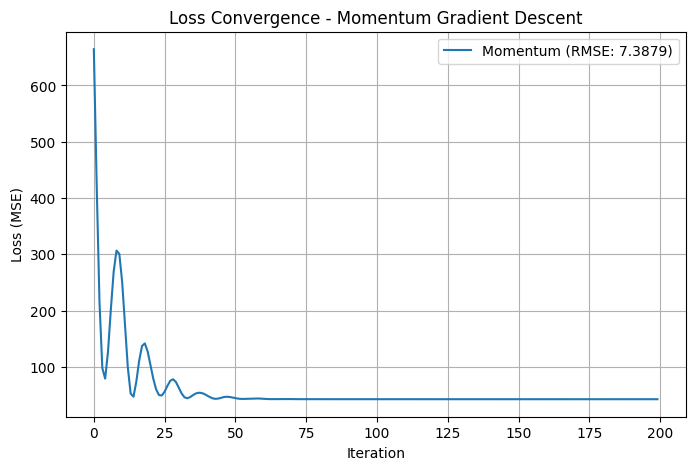

In [86]:
# Train Momentum Gradient Descent
print("Training Momentum...")
optimizer_momentum = optimizers['Momentum']
optimizer_momentum.loss_history = []  # Reset loss history
weights_momentum, bias_momentum = optimizer_momentum.momentum(X_train, y_train)
y_pred_momentum = predict(X_test, weights_momentum, bias_momentum)
rmse_momentum = rmse(y_test, y_pred_momentum)
print(f"RMSE: {rmse_momentum:.4f}")

# Plot loss convergence
plt.figure(figsize=(8, 5))
plt.plot(optimizer_momentum.loss_history, label=f'Momentum (RMSE: {rmse_momentum:.4f})')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('Loss Convergence - Momentum Gradient Descent')
plt.legend()
plt.grid()
plt.show()

Training RMSprop...
RMSE: 7.5419


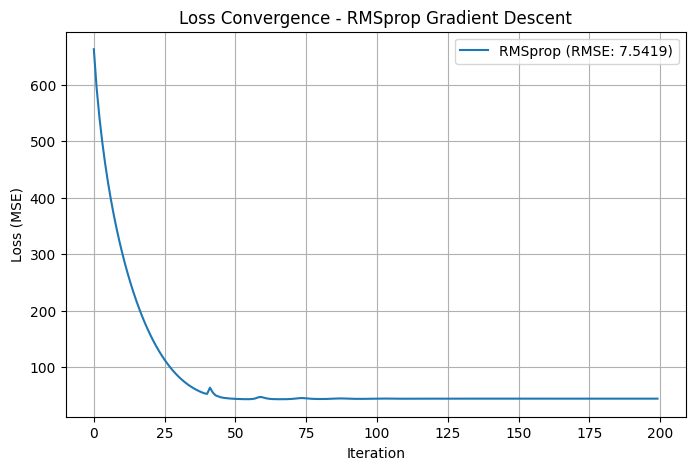

In [87]:
# Train RMSprop Gradient Descent
print("Training RMSprop...")
optimizer_rmsprop = optimizers['RMSprop']
optimizer_rmsprop.loss_history = []  # Reset loss history
weights_rmsprop, bias_rmsprop = optimizer_rmsprop.rmsprop(X_train, y_train)
y_pred_rmsprop = predict(X_test, weights_rmsprop, bias_rmsprop)
rmse_rmsprop = rmse(y_test, y_pred_rmsprop)
print(f"RMSE: {rmse_rmsprop:.4f}")

# Plot loss convergence
plt.figure(figsize=(8, 5))
plt.plot(optimizer_rmsprop.loss_history, label=f'RMSprop (RMSE: {rmse_rmsprop:.4f})')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('Loss Convergence - RMSprop Gradient Descent')
plt.legend()
plt.grid()
plt.show()

Training Adam...
RMSE: 7.3879


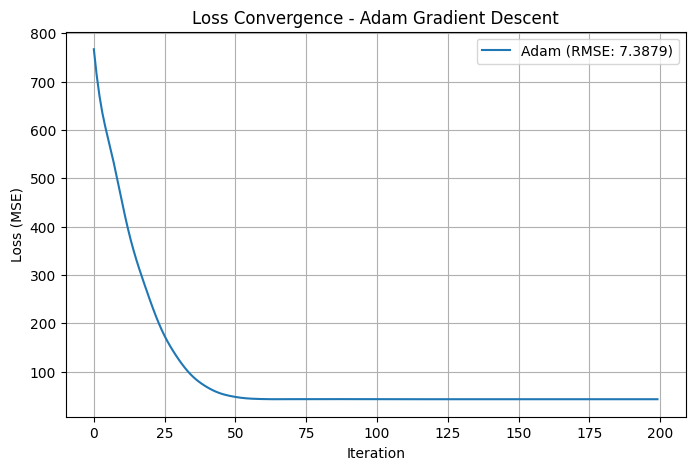

In [88]:
# Train Adam Gradient Descent
print("Training Adam...")
optimizer_adam = optimizers['Adam']
optimizer_adam.loss_history = []  # Reset loss history
weights_adam, bias_adam = optimizer_adam.adam(X_train, y_train)
y_pred_adam = predict(X_test, weights_adam, bias_adam)
rmse_adam = rmse(y_test, y_pred_adam)
print(f"RMSE: {rmse_adam:.4f}")
# Plot loss convergence
plt.figure(figsize=(8, 5))
plt.plot(optimizer_adam.loss_history, label=f'Adam (RMSE: {rmse_adam:.4f})')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('Loss Convergence - Adam Gradient Descent')
plt.legend()
plt.grid()
plt.show()